# COVID-19 Data Analysis
**Joe Corliss**

[Data source](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

## Execution Options

In [885]:
# Config
DATA_PATH = '../data/'
random_state = 0

# Modeling
metric = 'deaths'  # Variable of interest
metric_min = {'confirmed': round(2**9), 'deaths': 2**4}  # Filter out samples where the metric is below this value
log_metric = True  # Take log of the metric?
days_history = 5  # Number of consecutive past days to use for prediction (including the current day)
days_horizon = 7  # Number of days ahead to predict

In [886]:
# Validate input
assert isinstance(DATA_PATH, str), "Bad input for option 'DATA_PATH'"
assert isinstance(random_state, int), "Bad input for option 'random_state'"
assert metric in {'confirmed', 'deaths'}, "Bad input for option 'metric'"
assert isinstance(metric_min, dict), "Bad input for option 'metric_min'"
assert isinstance(log_metric, bool), "Bad input for option 'log_metric'"
assert isinstance(days_history, int) and days_history >= 1, "Bad input for option 'days_history'"
assert isinstance(days_horizon, int) and days_horizon >= 1, "Bad input for option 'days_horizon'"

## Imports

In [887]:
import sys

In [888]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

In [889]:
# Check package versions
assert sys.version.split()[0] == '3.6.10', 'Unexpected Python version: expected 3.6.10, got {}'.format(sys.version.split()[0])
assert mpl.__version__ == '3.1.3', 'Unexpected matplotlib version: expected 3.1.3, got {}'.format(mpl.__version__)
assert np.__version__ == '1.18.1', 'Unexpected numpy version: expected 1.18.1, got {}'.format(np.__version__)
assert pd.__version__ == '1.0.3', 'Unexpected pandas version: expected 1.0.3, got {}'.format(pd.__version__)
assert sklearn.__version__ == '0.22.1', 'Unexpected scikit-learn version: expected 0.22.1, got {}'.format(sklearn.__version__)

In [890]:
from sklearn import linear_model
from sklearn import model_selection

In [891]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

## Functions

## Load data

In [892]:
values = pd.read_csv(DATA_PATH + 'time_series_covid19_{metric}_global.txt'.format(metric=metric))

In [893]:
print('Data updated to:', values.columns[-1])

Data updated to: 3/30/20


In [894]:
values.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 73 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  79 non-null     object 
 1   Country/Region  254 non-null    object 
 2   Lat             254 non-null    float64
 3   Long            254 non-null    float64
 4   1/22/20         254 non-null    int64  
 5   1/23/20         254 non-null    int64  
 6   1/24/20         254 non-null    int64  
 7   1/25/20         254 non-null    int64  
 8   1/26/20         254 non-null    int64  
 9   1/27/20         254 non-null    int64  
 10  1/28/20         254 non-null    int64  
 11  1/29/20         254 non-null    int64  
 12  1/30/20         254 non-null    int64  
 13  1/31/20         254 non-null    int64  
 14  2/1/20          254 non-null    int64  
 15  2/2/20          254 non-null    int64  
 16  2/3/20          254 non-null    int64  
 17  2/4/20          254 non-null    int

Check that there is no unexpected missing data:

In [895]:
assert (~values.isnull().any()[1:]).all(), 'Unexpected missing data!'

In [896]:
values.drop(columns={'Lat', 'Long'}, inplace=True)

In [897]:
values.rename(columns={'Country/Region': 'country', 'Province/State': 'province'}, inplace=True)

In [898]:
values.sample(5)

,province,country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
220,Gibraltar,United Kingdom,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
148,NaN,Liberia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
74,Shanghai,China,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,5,5,5,5,5,5
161,NaN,Mongolia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
93,Greenland,Denmark,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Look at Countries Split Up by Province/State

Number of distinct provinces for countries with more than one province:

In [899]:
country_counts = values['country'].value_counts()
print(country_counts[country_counts > 1])

China             33
Canada            15
France            10
United Kingdom    10
Australia          8
Netherlands        4
Denmark            3
Name: country, dtype: int64


List current value by country and province, sorted by country ascending, then value descending:

In [900]:
values.loc[values['country'].map(country_counts > 1)].iloc[:, [1, 0, -1]].sort_values(
    ['country', values.columns[-1]], ascending=[True, False]
)

,country,province,3/30/20
9,Australia,New South Wales,8
14,Australia,Victoria,4
11,Australia,Queensland,2
15,Australia,Western Australia,2
8,Australia,Australian Capital Territory,1
10,Australia,Northern Territory,0
12,Australia,South Australia,0
13,Australia,Tasmania,0
42,Canada,Ontario,31
44,Canada,Quebec,22


## Data Processing

Add a new variable `locale` that combines the country and provice (if applicable):

In [901]:
values.insert(0, 'locale', values['country'].where(
    values['province'].isnull(),
    values['country'] + '/' + values['province']
))

Replaces the `country` and `province` columns:

In [902]:
values.drop(columns={'province', 'country'}, inplace=True)

In [903]:
values.sample(5)

,locale,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
145,Kyrgyzstan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
180,Paraguay,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,3,3,3,3,3,3
201,Spain,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,5,10,17,28,35,54,55,133,195,289,342,533,623,830,1043,1375,1772,2311,2808,3647,4365,5138,5982,6803,7716
24,Benin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
114,France/St Martin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Plot values for each locale (repeat the second cell below) - Skip locales with fewer than 1,000 cases today:

In [904]:
idx = 0

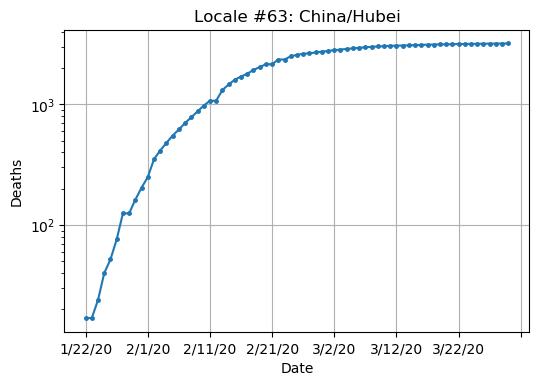

In [905]:
if idx < values.shape[0]:
    while values.iloc[idx, -1] < 1000:
        idx += 1
    plt.figure(dpi=100)
    values.iloc[idx, 1:].plot.line(marker='.', markersize=5, logy=log_metric)
    plt.title('Locale #{idx}: {locale}'.format(idx=idx + 1, locale=values.iloc[idx, 0]))
    plt.xlabel('Date')
    plt.ylabel(metric.capitalize())
    plt.grid(True)
    idx += 1

Stack the data:

In [906]:
values_melt = values.melt(id_vars=['locale'], var_name='date', value_name='value')

In [907]:
values_melt['date'] = pd.to_datetime(values_melt['date'])

In [908]:
values_melt.sample(5)

,locale,date,value
13860,Kuwait,2020-03-16,0
10630,United Arab Emirates,2020-03-03,0
9412,Australia/Victoria,2020-02-28,0
6194,Egypt,2020-02-15,0
9467,China/Macau,2020-02-28,0


Filter by the minimum required metric value:

In [909]:
values_melt = values_melt.loc[values_melt['value'] >= metric_min[metric]]

Apply log to the metric values, if specified:

In [910]:
if log_metric:
    values_melt['value'] = values_melt['value'].map(np.log10)

In [911]:
values_melt.sample(5)

,locale,date,value
16135,Iran,2020-03-25,3.317436
16692,Philippines,2020-03-27,1.732394
15106,Germany,2020-03-21,1.924279
11319,"Korea, South",2020-03-06,1.623249
17497,US,2020-03-30,3.473925


## Construct Final Datasets

In [912]:
final_schema = pd.DataFrame(columns=['locale', 'date']
                                    + ['value_d{}'.format(idx) for idx in range(-days_history + 1, 1)]
                                    + ['value_d+{}'.format(days_horizon)])

In [913]:
final_schema

,locale,date,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7


In [914]:
train_to_append_list = []
pred_to_append_list = []

In [915]:
for locale in sorted(values_melt['locale'].unique()):
    values_melt_locale = values_melt.loc[values_melt['locale'] == locale].sort_values('date')
    
    # Add to training data
    for idx in range(values_melt_locale.shape[0] - days_history - days_horizon + 1):
        train_to_append = values_melt_locale.iloc[idx + (days_history - 1), :2].to_dict()
        train_to_append.update(zip(final_schema.columns[2:-1], values_melt_locale['value'].iloc[idx : idx + days_history]))
        train_to_append[final_schema.columns[-1]] = values_melt_locale['value'].iloc[idx + (days_history - 1) + days_horizon]
        train_to_append_list.append(train_to_append)
        
    # Add to prediction data
    if days_history <= values_melt_locale.shape[0]:  # Can only predict if we have enough days of history
        pred_to_append = values_melt_locale.iloc[-1, :2].to_dict()
        pred_to_append.update(zip(final_schema.columns[2:-1], values_melt_locale['value'].iloc[-days_history:]))
        pred_to_append_list.append(pred_to_append)

In [916]:
train = final_schema.append(train_to_append_list, ignore_index=True)
pred = final_schema.append(pred_to_append_list, ignore_index=True)

In [917]:
train.set_index(['locale', 'date'], inplace=True, verify_integrity=True)
pred.set_index(['locale', 'date'], inplace=True, verify_integrity=True)

Check the size of the dataset:

In [918]:
print('The training data has {} samples'.format(train.shape[0]))
print('Predictions will be made for {} locales'.format(pred.shape[0]))

The training data has 224 samples
Predictions will be made for 33 locales


In [919]:
train.head()

value_d-4  value_d-3  value_d-2  value_d-1  value_d0  \
locale      date                                                               
Belgium     2020-03-23   1.322219   1.568202   1.826075   1.875061  1.944483   
China/Henan 2020-02-21   1.204120   1.278754   1.278754   1.278754  1.278754   
            2020-02-22   1.278754   1.278754   1.278754   1.278754  1.278754   
            2020-02-23   1.278754   1.278754   1.278754   1.278754  1.278754   
            2020-02-24   1.278754   1.278754   1.278754   1.278754  1.278754   

                        value_d+7  
locale      date                   
Belgium     2020-03-23   2.710117  
China/Henan 2020-02-21   1.301030  
            2020-02-22   1.322219  
            2020-02-23   1.342423  
            2020-02-24   1.342423

In [920]:
pred.head()

,,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7
locale,date,,,,,,
Algeria,2020-03-30,1.397940,1.414973,1.462398,1.491362,1.544068,NaN
Austria,2020-03-30,1.690196,1.763428,1.832509,1.934498,2.033424,NaN
Belgium,2020-03-30,2.342423,2.460898,2.547775,2.634477,2.710117,NaN
Brazil,2020-03-30,1.886491,1.963788,2.045323,2.133539,2.201397,NaN
China/Henan,2020-03-30,1.342423,1.342423,1.342423,1.342423,1.342423,NaN


Shuffle the training data:

In [921]:
train = train.sample(frac=1, random_state=random_state)

## Maching Learning

In [922]:
model = linear_model.LassoCV(
    eps=1e-8,
    fit_intercept=True,
    max_iter=100000,
    verbose=False,
    n_jobs=-1,
    random_state=random_state,
)

In [923]:
model.fit(train.iloc[:, :-1], train.iloc[:, -1])

LassoCV(alphas=None, copy_X=True, cv=None, eps=1e-08, fit_intercept=True,
        max_iter=100000, n_alphas=100, n_jobs=-1, normalize=False,
        positive=False, precompute='auto', random_state=0, selection='cyclic',
        tol=0.0001, verbose=False)

In [924]:
model.coef_

array([-0.87805368, -0.56070834, -0.        ,  0.22202471,  2.18613447])

Number of historical days (features) selected:

In [925]:
(model.coef_ != 0).sum()

4

In [926]:
model.intercept_

0.11027586398660771

In [927]:
model.alpha_

0.000578322565212672

In [928]:
min(model.alphas_), max(model.alphas_)

(5.650269047436107e-09, 0.5650269047436103)

In [929]:
model.n_iter_

1259

Cross-validated mean absolute error:

In [930]:
mean_abs_errors = -model_selection.cross_val_score(
    estimator=linear_model.Lasso(
        alpha=model.alpha_,
        max_iter=100000,
        random_state=random_state,
    ),
    X=train.iloc[:, :-1],
    y=train.iloc[:, -1],
    scoring='neg_mean_absolute_error',
)

In [937]:
sorted(mean_abs_errors)

[0.07087137593599849,
 0.08230704761561411,
 0.09487302831999814,
 0.09990389489983831,
 0.10039860106107541]

Model selection metric:

In [932]:
mean_abs_errors.mean()

0.0896707895665049

## Predictions

In [934]:
pred['value_d+{}'.format(days_horizon)] = model.predict(pred.iloc[:, :-1])

In [935]:
if log_metric:
    for col in pred.columns:
        pred[col] = pred[col].map(lambda x: round(10**x))

In [936]:
pred

,,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7
locale,date,,,,,,
Algeria,2020-03-30,25,26,29,31,35,63
Austria,2020-03-30,49,58,68,86,108,325
Belgium,2020-03-30,220,289,353,431,513,1525
Brazil,2020-03-30,77,92,111,136,159,435
China/Henan,2020-03-30,22,22,22,22,22,26
China/Hubei,2020-03-30,3169,3174,3177,3182,3186,3230
Denmark,2020-03-30,41,52,65,72,77,186
Ecuador,2020-03-30,34,36,48,58,60,148
Egypt,2020-03-30,24,30,36,40,41,89
